In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install split-folders

In [3]:
import tensorflow as tf
tf.random.set_seed(42)
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pathlib
import splitfolders
import shutil
import warnings
import numpy as np
np.random.seed(42)
warnings.filterwarnings('ignore')

In [4]:
normal = "/content/drive/MyDrive/cse498r/normal"
pneumonia = "/content/drive/MyDrive/cse498r/pneumonia"

print(len(os.listdir(normal)))
print(len(os.listdir(pneumonia)))

515
114


data **augmentation**

In [5]:
main_dir = 'temp'
os.mkdir(main_dir)
no_dir = os.path.join(main_dir, 'no')
os.mkdir(no_dir)
yes_dir = os.path.join(main_dir, 'yes')
os.mkdir(yes_dir)

In [8]:
aug_dir = 'aug_dir'
os.mkdir(aug_dir)


img_dir = os.path.join(aug_dir, 'img_dir')
os.mkdir(img_dir)
img_class = 'normal'
img_list = os.listdir('/content/drive/MyDrive/cse498r' + img_class)


for fname in img_list:
    # source path to image
    src = os.path.join('/content/drive/MyDrive/cse498r' + img_class, fname)
    # destination path to image
    dst = os.path.join(img_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
path = aug_dir
save_path = '/content/drive/MyDrive/cse498r' + img_class

# Create a data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest')

batch_size = 1

aug_datagen = datagen.flow_from_directory(path,
                                          save_to_dir=save_path,
                                          save_format='jpg',
                                          target_size=(224,224),
                                          batch_size=batch_size)



num_aug_images_wanted = 250
# (Note: We may or may not get the intended num of augmented images, so play will the number. I put 250 here to get 150 images)

num_files = len(os.listdir(img_dir))
num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

# run the generator and create our augmented images
for i in range(0,num_batches):
    imgs, labels = next(aug_datagen)

# delete temporary directory with the raw image files
shutil.rmtree('aug_dir')

FileExistsError: ignored

In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [10]:
import os
import pathlib

In [12]:
data_path = pathlib.Path("/content/drive/MyDrive/cse498r")

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, seed=123,
    shuffle=True,
    image_size = (224, 224),
    batch_size = 68
)

Found 629 files belonging to 2 classes.


In [14]:
class_names = dataset.class_names

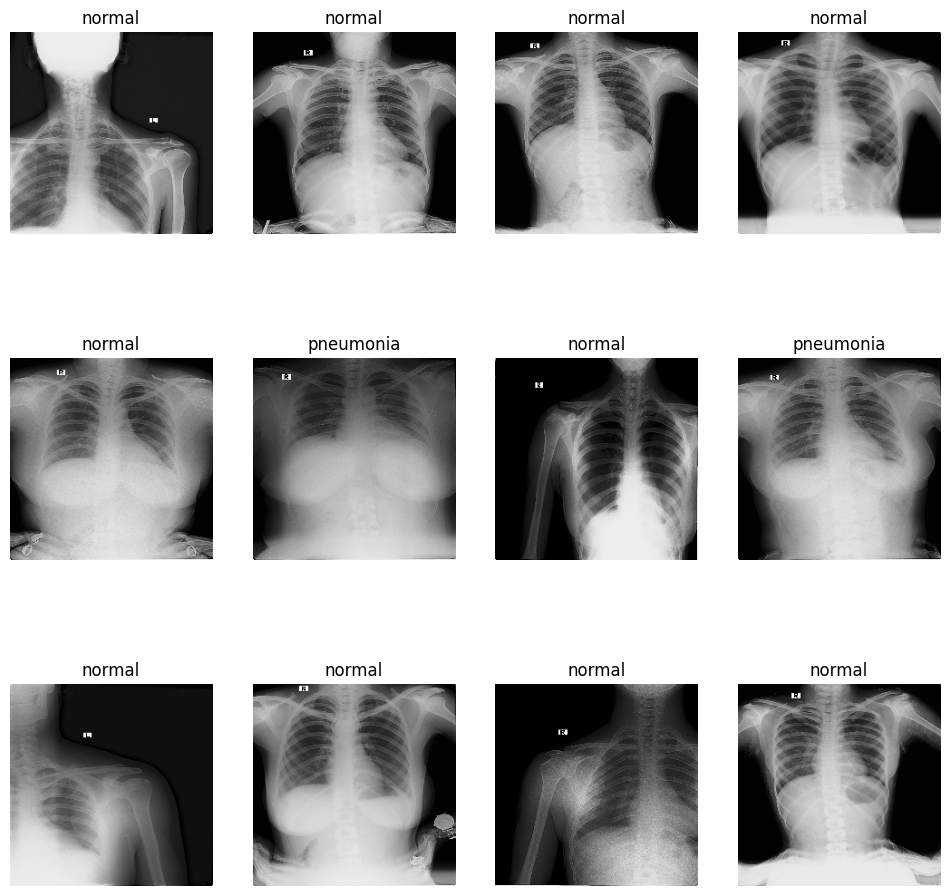

In [15]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [16]:
def split_data(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=699):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size, seed=123)

    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, test_ds, val_ds

In [17]:
train_ds, test_ds, val_ds = split_data(dataset)

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

train_ds = train_ds.map(lambda x,y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224, 224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet")

vgg16.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.vgg16.preprocess_input(
    inputs, data_format=None)

x = vgg16(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
outputs = tf.keras.layers.Dense(2, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

58889256/58889256 [==============================] - 2s 0us/step


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                             

In [23]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)

In [24]:
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, verbose=1, mode='auto')

cb = [checkpoint, early]

In [26]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks = cb)

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 10.5191 - accuracy: 0.6599

8/8 [==============================] - 43s 2s/step - loss: 10.5191 - accuracy: 0.6599 - val_loss: 1.4302 - val_accuracy: 0.2353
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.7261

8/8 [==============================] - 5s 645ms/step - loss: 0.5547 - accuracy: 0.7261 - val_loss: 0.4993 - val_accuracy: 0.7647
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.8217

8/8 [==============================] - 5s 646ms/step - loss: 0.3901 - accuracy: 0.8217 - val_loss: 0.4304 - val_accuracy: 0.7647
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.3788 - accuracy: 0.8180

8/8 [==============================] - 5s 654ms/step - loss: 0.3788 - accuracy: 0.8180 - val_loss: 0.4012 - val_accuracy: 0.7647
Epoch 5/30
8/8 [==============================] - ETA: 0s - loss: 0.3669 - accuracy: 0.8272

8/8 [==============================] - 6s 670ms/step - loss: 0.3669 - accuracy: 0.8272 - val_loss: 0.3936 - val_accuracy: 0.8088
Epoch 6/30
8/8 [==============================] - ETA: 0s - loss: 0.3659 - accuracy: 0.8235

8/8 [==============================] - 5s 622ms/step - loss: 0.3659 - accuracy: 0.8235 - val_loss: 0.3677 - val_accuracy: 0.7941
Epoch 7/30
8/8 [==============================] - ETA: 0s - loss: 0.3728 - accuracy: 0.8235

8/8 [==============================] - 6s 726ms/step - loss: 0.3728 - accuracy: 0.8235 - val_loss: 0.3686 - val_accuracy: 0.8529
Epoch 8/30
8/8 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.8346

8/8 [==============================] - 5s 670ms/step - loss: 0.3511 - accuracy: 0.8346 - val_loss: 0.3559 - val_accuracy: 0.7794
Epoch 9/30
8/8 [==============================] - ETA: 0s - loss: 0.3568 - accuracy: 0.8199

8/8 [==============================] - 5s 624ms/step - loss: 0.3568 - accuracy: 0.8199 - val_loss: 0.3434 - val_accuracy: 0.7941
Epoch 10/30
8/8 [==============================] - ETA: 0s - loss: 0.3485 - accuracy: 0.8364

8/8 [==============================] - 6s 671ms/step - loss: 0.3485 - accuracy: 0.8364 - val_loss: 0.3512 - val_accuracy: 0.7647
Epoch 11/30
8/8 [==============================] - ETA: 0s - loss: 0.3547 - accuracy: 0.8217

8/8 [==============================] - 6s 725ms/step - loss: 0.3547 - accuracy: 0.8217 - val_loss: 0.3108 - val_accuracy: 0.8676
Epoch 12/30
8/8 [==============================] - ETA: 0s - loss: 0.3512 - accuracy: 0.8548

8/8 [==============================] - 5s 645ms/step - loss: 0.3512 - accuracy: 0.8548 - val_loss: 0.3528 - val_accuracy: 0.7941
Epoch 13/30
8/8 [==============================] - ETA: 0s - loss: 0.3478 - accuracy: 0.8419

8/8 [==============================] - 6s 755ms/step - loss: 0.3478 - accuracy: 0.8419 - val_loss: 0.3593 - val_accuracy: 0.7647
Epoch 14/30
8/8 [==============================] - ETA: 0s - loss: 0.3567 - accuracy: 0.8309

8/8 [==============================] - 5s 654ms/step - loss: 0.3567 - accuracy: 0.8309 - val_loss: 0.3431 - val_accuracy: 0.8529
Epoch 15/30
8/8 [==============================] - ETA: 0s - loss: 0.3437 - accuracy: 0.8309

8/8 [==============================] - 6s 705ms/step - loss: 0.3437 - accuracy: 0.8309 - val_loss: 0.3392 - val_accuracy: 0.8088
Epoch 16/30
8/8 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.8382

8/8 [==============================] - 5s 651ms/step - loss: 0.3233 - accuracy: 0.8382 - val_loss: 0.3196 - val_accuracy: 0.8235
Epoch 17/30
8/8 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.8474

8/8 [==============================] - 5s 661ms/step - loss: 0.3427 - accuracy: 0.8474 - val_loss: 0.3539 - val_accuracy: 0.7941
Epoch 18/30
8/8 [==============================] - ETA: 0s - loss: 0.3308 - accuracy: 0.8456

8/8 [==============================] - 6s 719ms/step - loss: 0.3308 - accuracy: 0.8456 - val_loss: 0.3102 - val_accuracy: 0.8382
Epoch 19/30
8/8 [==============================] - ETA: 0s - loss: 0.3307 - accuracy: 0.8382

8/8 [==============================] - 6s 690ms/step - loss: 0.3307 - accuracy: 0.8382 - val_loss: 0.3117 - val_accuracy: 0.8824
Epoch 20/30
8/8 [==============================] - ETA: 0s - loss: 0.3451 - accuracy: 0.8493

8/8 [==============================] - 5s 665ms/step - loss: 0.3451 - accuracy: 0.8493 - val_loss: 0.3333 - val_accuracy: 0.8235
Epoch 21/30
8/8 [==============================] - ETA: 0s - loss: 0.3350 - accuracy: 0.8419

8/8 [==============================] - 6s 756ms/step - loss: 0.3350 - accuracy: 0.8419 - val_loss: 0.3656 - val_accuracy: 0.7794
Epoch 22/30
8/8 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.8529

8/8 [==============================] - 5s 638ms/step - loss: 0.3194 - accuracy: 0.8529 - val_loss: 0.2893 - val_accuracy: 0.8529
Epoch 23/30
8/8 [==============================] - ETA: 0s - loss: 0.3336 - accuracy: 0.8419

8/8 [==============================] - 6s 699ms/step - loss: 0.3336 - accuracy: 0.8419 - val_loss: 0.3293 - val_accuracy: 0.8235
Epoch 24/30
8/8 [==============================] - ETA: 0s - loss: 0.3204 - accuracy: 0.8511

8/8 [==============================] - 5s 653ms/step - loss: 0.3204 - accuracy: 0.8511 - val_loss: 0.3095 - val_accuracy: 0.8382
Epoch 25/30
8/8 [==============================] - ETA: 0s - loss: 0.3437 - accuracy: 0.8511

8/8 [==============================] - 5s 660ms/step - loss: 0.3437 - accuracy: 0.8511 - val_loss: 0.3072 - val_accuracy: 0.8529
Epoch 26/30
8/8 [==============================] - ETA: 0s - loss: 0.3384 - accuracy: 0.8327

8/8 [==============================] - 6s 728ms/step - loss: 0.3384 - accuracy: 0.8327 - val_loss: 0.3660 - val_accuracy: 0.7794
Epoch 27/30
8/8 [==============================] - ETA: 0s - loss: 0.3437 - accuracy: 0.8548

8/8 [==============================] - 5s 642ms/step - loss: 0.3437 - accuracy: 0.8548 - val_loss: 0.3183 - val_accuracy: 0.8529
Epoch 28/30
8/8 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8603

8/8 [==============================] - 6s 721ms/step - loss: 0.3199 - accuracy: 0.8603 - val_loss: 0.2905 - val_accuracy: 0.8529
Epoch 29/30
8/8 [==============================] - ETA: 0s - loss: 0.3160 - accuracy: 0.8585

8/8 [==============================] - 6s 676ms/step - loss: 0.3160 - accuracy: 0.8585 - val_loss: 0.3082 - val_accuracy: 0.8382
Epoch 30/30
8/8 [==============================] - ETA: 0s - loss: 0.3285 - accuracy: 0.8566

8/8 [==============================] - 6s 785ms/step - loss: 0.3285 - accuracy: 0.8566 - val_loss: 0.3212 - val_accuracy: 0.8676
